# Tracing ttnn operations and torch modules/functions

If you're using a Wormhole card (N150/N300), you will need to set the full Tensix available to be able to continue with this tutorial

In [1]:
import os
os.environ["WH_ARCH_YAML"] = "wormhole_b0_80_arch_eth_dispatch.yaml"
os.environ["TTNN_CONFIG_OVERRIDES"] = "{\"enable_fast_runtime_mode\": false}"

In [3]:
import torch
import transformers

import ttnn
from ttnn.tracer import trace, visualize

NameError: name 'library_tweaks' is not defined

In [ ]:
transformers.logging.set_verbosity_error()

## Trace torch functions

2024-08-21 06:15:22.746 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


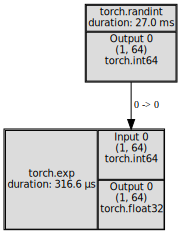

In [ ]:
with trace():
    tensor = torch.randint(0, 100, (1, 64))
    tensor = torch.exp(tensor)
visualize(tensor)

## Trace torch functions and ttnn operations

2024-08-21 06:16:28.751 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


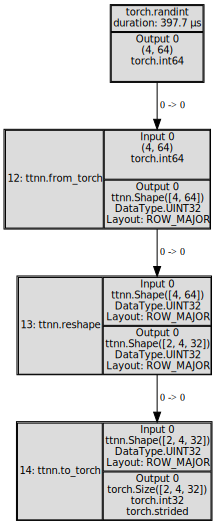

In [ ]:
with trace():
    tensor = torch.randint(0, 100, (4, 64))
    tensor = ttnn.from_torch(tensor)
    tensor = ttnn.reshape(tensor, (2, 4, 32))
    tensor = ttnn.to_torch(tensor)
visualize(tensor)

## Trace torch functions, torch modules and ttnn operations

/home/thienluu/tt/tt-metal/python_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

2024-08-21 06:17:27.024 | DEBUG    | ttnn.tracer:visualize:443 - Dumping graph of the model to None


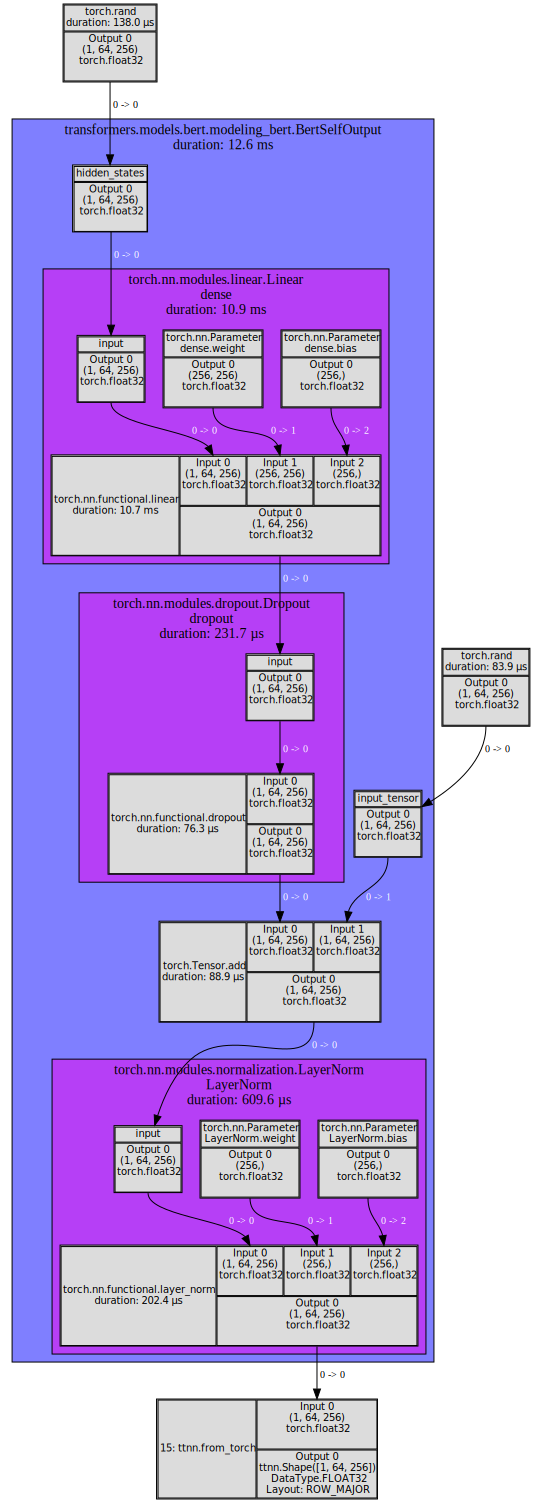

In [ ]:
model_name = "google/bert_uncased_L-4_H-256_A-4"
config = transformers.BertConfig.from_pretrained(model_name)
model = transformers.models.bert.modeling_bert.BertSelfOutput(config).eval()

with trace():
    hidden_states = torch.rand((1, 64, config.hidden_size))
    input_tensor = torch.rand((1, 64, config.hidden_size))
    hidden_states = model(hidden_states, input_tensor)
    output = ttnn.from_torch(hidden_states)
visualize(output)

## Trace models written using ttnn

In [ ]:
device = ttnn.open_device(device_id=0, l1_small_size=8192)

                 Device | INFO     | Opening user mode device driver
2024-08-21 06:17:51.137 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.229 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.252 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.269 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.282 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.304 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.320 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
2024-08-21 06:17:51.332 | INFO     | SiliconDriver   - Detected 8 PCI devices : [0, 1, 2, 3, 4, 5, 6, 7]
                  Metal | INFO     | Initializing device 0. Program cache is NOT enabled
  

In [ ]:
from models.demos.bert.tt import ttnn_bert
from models.demos.bert.tt import ttnn_optimized_bert
from ttnn.model_preprocessing import preprocess_model_parameters

def ttnn_bert(bert):
    model_name = "phiyodr/bert-large-finetuned-squad2"
    
    config = transformers.BertConfig.from_pretrained(model_name)
    config.num_hidden_layers = 1
    
    batch_size = 8
    sequence_size = 384
            
    parameters = preprocess_model_parameters(
        initialize_model=lambda: transformers.BertForQuestionAnswering.from_pretrained(
            model_name, config=config
        ).eval(),
        custom_preprocessor=bert.custom_preprocessor,
        device=device,
    )

    with trace():
        input_ids = torch.randint(0, config.vocab_size, (batch_size, sequence_size)).to(torch.int32)
        torch_token_type_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_position_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_attention_mask = torch.zeros(1, sequence_size) if bert == ttnn_optimized_bert else None
        

        ttnn_bert_inputs = bert.preprocess_inputs(
            input_ids,
            torch_token_type_ids,
            torch_position_ids,
            torch_attention_mask,
            device=device,
        )
    
        output = bert.bert_for_question_answering(
            config,
            *ttnn_bert_inputs,
            parameters=parameters,
        )
        output = ttnn.from_device(output)
        
    return visualize(output)

In [ ]:
ttnn_bert(ttnn_optimized_bert)

/home/thienluu/tt/tt-metal/python_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-08-21 06:18:20.273 | DEBUG    | ttnn:manage_config:90 - Set ttnn.CONFIG.enable_logging to False
2024-08-21 06:18:20.274 | DEBUG    | ttnn:manage_config:90 - Set ttnn.CONFIG.enable_comparison_mode to False
2024-08-21 06:18:20.275 | WARNING  | ttnn.model_preprocessing:from_torch:555 - ttnn: model cache can be enabled by passing model_name argument to preprocess_model[_parameters] and setting env variable TTNN_CONFIG_OVERRIDES='{"enable_model_cache": true}'


2024-08-21 06:18:21.125 | DEBUG    | ttnn.model_preprocessing:from_torch:634 - Moving model weights to device
2024-08-21 06:18:21.144 | DEBUG    | ttnn.model_preprocessing:from_torch:636 - Moved model weights to device
2024-08-21 06:18:21.145 | DEBUG    | ttnn:manage_config:93 - Restored ttnn.CONFIG.enable_comparison_mode to False
2024-08-21 06:18:21.146 | DEBUG    | ttnn:manage_config:93 - Restored ttnn.CONFIG.enable_logging to False


In [ ]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
                  Metal | INFO     | Disabling and clearing program cache on device 0
